# Proyek 1: Membuat Model NLP dengan TensorFlow
---

Oleh: Mohammad Aditya Rafi Pratama (madityarafip - madityarafip31@gmail.com) - Depok, Indonesia

Pada proyek ini akan dirancang sebuah model NLP dari Machine Learning yang bertujuan untuk mengklasifikasi sebuah teks berita apakah termasuk kedalam kategori berita *business*, *entertainment*, *politics*, *sport*, atau *tech*.
---

---

Proses pertama adalah import library yang digunakan

In [ ]:
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from google.colab import files



Dengan memanfaatkan library yang tersedia pada Google Colab, dataset yang diperlukan akan diupload menggunakan fungsi upload.

In [ ]:
uploaded = files.upload()

Saving bbc-news-data.csv to bbc-news-data.csv


Setelah data berhasil diload, langkah selanjutnya adalah membaca file .csv dari dataset yang digunakan dengan menggunakan fungsi yang terdapat pada library pandas.

In [ ]:
df = pd.read_csv('bbc-news-data.csv', sep=None)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


Dapat dilihat pada tampilan data terdapat 4 kolom yang terbaca. Pada proyek ini hanya menggunakan 2 kolom yaitu, kolom *content* dan kolom *category*. Sehingga kedua kolom sisanya dapat dihilangkan dengan fungsi drop.

In [ ]:
df = df.drop(columns=['filename'])
df = df.drop(columns=['title'])
df.head()

,category,content
0,business,Quarterly profits at US media giant TimeWarne...
1,business,The dollar has hit its highest level against ...
2,business,The owners of embattled Russian oil giant Yuk...
3,business,British Airways has blamed high fuel prices f...
4,business,Shares in UK drinks and food firm Allied Dome...


Karena label berupa data kategorikal, maka perlu dilakukan proses one-hot-encoding.

In [ ]:
category = pd.get_dummies(df.category)
new_df = pd.concat([df, category], axis=1)
new_df = new_df.drop(columns='category')
new_df

,content,business,entertainment,politics,sport,tech
0,Quarterly profits at US media giant TimeWarne...,1,0,0,0,0
1,The dollar has hit its highest level against ...,1,0,0,0,0
2,The owners of embattled Russian oil giant Yuk...,1,0,0,0,0
3,British Airways has blamed high fuel prices f...,1,0,0,0,0
4,Shares in UK drinks and food firm Allied Dome...,1,0,0,0,0
...,...,...,...,...,...,...
2220,BT is introducing two initiatives to help bea...,0,0,0,0,1
2221,Computer users across the world continue to i...,0,0,0,0,1
2222,A new European directive could put software w...,0,0,0,0,1
2223,The man making sure US computer networks are ...,0,0,0,0,1


Proses selanjutnya adalah membagi data 
training dan data testing

In [ ]:
content = new_df['content'].values
tags = new_df[['business','entertainment','politics','sport','tech']]

In [ ]:
content_train, content_test, tags_train, tags_test = train_test_split(content, tags, test_size=0.2)

Kemudian ubah setiap kata pada dataset ke dalam bilangan numerik dengan fungsi Tokenizer. Setelah tokenisasi selesai, perlu dilakukan konversi setiap sampel menjadi sequence

In [ ]:
tokenizer = Tokenizer(num_words=50000, oov_token='-', lower=False)tokenizer.fit_on_texts(content_train) 
tokenizer.fit_on_texts(content_test)
     
content_train = tokenizer.texts_to_sequences(content_train)
content_test = tokenizer.texts_to_sequences(content_test)
     
padded_train = pad_sequences(content_train) 
padded_test = pad_sequences(content_test)

Untuk arsitektur model menggunakan layer Embedding dengan dimensi embedding sebesar 20, serta dimensi dari input sebesar nilai num_words pada objek tokenizer. Pada model ini juga digunakan fungsi dropout sebersar 20% yang berfungsi untuk mengatasi overfitting.

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=50000, output_dim=20),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Sebelum masuk proses melatih/training model dibutuhkan proses callback yang berfungi untuk memberhentikan proses pelatihan ketika mencapai akurasi yang ditentukan, yang dimana pada proyek ini akan berhenti ketika mencapai akurasi >85%.

In [ ]:
class Callback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > 0.85 and logs.get('val_accuracy') > 0.85):
            print("\nReached 85% accuracy") 
            self.model.stop_training = True 
     
callbacks = Callback()

Proses selanjutnya adalah melatih model dengan menggunakan fungsi fit(). Pada proses ini juga akan dimasukkan nilai Epoch yang diinginkan dengan fungsi input().

In [ ]:
num_epochs = int(input('Epoch = '))
print(' ')
history = model.fit(padded_train, tags_train, 
                    epochs=num_epochs, 
                    validation_data=(padded_test, tags_test),
                    validation_steps=3, 
                    verbose=2,
                    callbacks=[callbacks]
                    )

Epoch = 30
 
Epoch 1/30
56/56 - 16s - loss: 1.6074 - accuracy: 0.2225 - val_loss: 1.5936 - val_accuracy: 0.2607
Epoch 2/30
56/56 - 7s - loss: 1.3887 - accuracy: 0.3483 - val_loss: 1.1956 - val_accuracy: 0.3573
Epoch 3/30
56/56 - 7s - loss: 0.9288 - accuracy: 0.5348 - val_loss: 0.9701 - val_accuracy: 0.6831
Epoch 4/30
56/56 - 7s - loss: 0.4969 - accuracy: 0.8028 - val_loss: 0.6764 - val_accuracy: 0.7663
Epoch 5/30
56/56 - 7s - loss: 0.2170 - accuracy: 0.9287 - val_loss: 0.6767 - val_accuracy: 0.7978
Epoch 6/30
56/56 - 7s - loss: 0.0719 - accuracy: 0.9775 - val_loss: 0.6241 - val_accuracy: 0.8404
Epoch 7/30
56/56 - 7s - loss: 0.0292 - accuracy: 0.9933 - val_loss: 0.7047 - val_accuracy: 0.8360
Epoch 8/30
56/56 - 7s - loss: 0.0166 - accuracy: 0.9927 - val_loss: 0.6962 - val_accuracy: 0.8180
Epoch 9/30
56/56 - 7s - loss: 0.0191 - accuracy: 0.9966 - val_loss: 0.8245 - val_accuracy: 0.8292
Epoch 10/30
56/56 - 7s - loss: 0.0099 - accuracy: 0.9966 - val_loss: 0.8885 - val_accuracy: 0.8022
Epoch

Setelah proses pelatihan selesai kita dapat melakukan plot akurasi dan loss yang dihasilkan oleh model untuk setiap epoch yang berjalan.

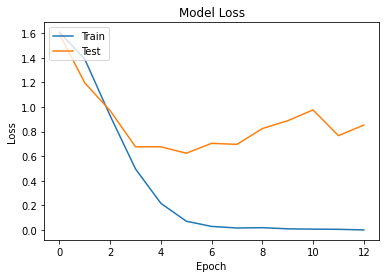

In [ ]:
#Grafik loss dari model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

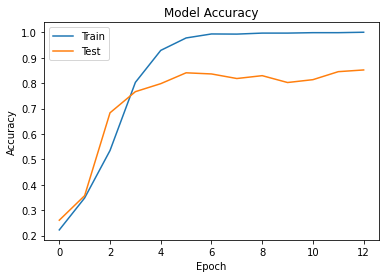

In [ ]:
#Grafik accuracy dari model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()